# QuantAlpha Engine V2 — 因子Zoo + 多因子融合完整演示

**v2.0 新增特性：**
```
ops/alpha_ops.py   ← +14 个预构建算子（时序/量价/动量/技术指标）
fusion/
├── labeler.py     ← Labeler：前向收益率标签生成器
├── combiner.py    ← StatisticalCombiner + MLCombiner
└── __init__.py
```

**演示内容：**

| 章节 | 内容 |
|------|------|
| §1   | 环境准备 + 框架导入 |
| §2   | 模拟数据生成 |
| §3   | 新增时序因子（Ts_Skew / Ts_Kurt / Ts_Autocorr / Ts_Hurst）|
| §4   | 新增量价因子（VWAP / VWAP_Bias / PVDeviation / Amihud）|
| §5   | 新增动量因子（RiskAdjMomentum / PricePathQuality / RangeBreakout）|
| §6   | 新增技术指标（RSI / KDJ / MACD）|
| §7   | Labeler — 前向收益率标签生成 |
| §8   | StatisticalCombiner — 统计多因子融合（3种权重）|
| §9   | MLCombiner — 机器学习融合（Expanding Window）|
| §10  | 融合效果对比 |
| §11  | 模型持久化（save / load）|

## §1. 环境准备 + 框架导入

In [1]:
# 确认当前工作目录（需要在 quant_alpha_engine 的父目录下运行）
import os
print('当前路径:', os.getcwd())

# 如果路径不对，取消注释并修改以下行：
# os.chdir(r'D:\Stock\Frame')  # ← 修改为实际路径

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Jupyter 内联显示图表
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

当前路径: d:\Stock\Frame


In [2]:
from data_loader import RepositoryDataLoader, MarketData
from quant_alpha_engine.ops import AlphaOps as op
from quant_alpha_engine.backtest import VectorEngine
from quant_alpha_engine.backtest.performance import Performance

print('✅ QuantAlpha Engine 导入成功')

✅ QuantAlpha Engine 导入成功


## §2. 数据生成

In [3]:
# ── 数据配置 ──────────────────────────────────────────────────
REPO_DIR   = './rawdata/repository'   # DataRepository 根目录
START_DATE = '2025-02-26'             # 回测起始日期
END_DATE   = '2026-02-26'             # 回测截止日期（None = 今天）
ADJ_TYPE   = 'hfq'                    # 'hfq'(后复权，推荐) | 'qfq'(前复权) | 'raw'(不复权)

# ── 数据过滤参数 ─────────────────────────────────────────────
MIN_TRADING_DAYS = 200     # 最少有效交易日，不足则剔除
MAX_NAN_PCT      = 0.0     # close 列最大允许 NaN 比例（0 = 严格无缺失）

# ── Step 1: 加载全部股票原始数据 ─────────────────────────────
print('► Step 1: 从仓库加载全部 OHLCV 数据...')
loader = RepositoryDataLoader(
    repo_dir     = REPO_DIR,
    limit_up_pct = 0.099,   # 涨跌停判断阈值（科创板/创业板可改为 0.199）
)

data_raw = loader.load(
    symbols          = None,              # None = 自动加载仓库中所有股票
    start_date       = START_DATE,
    end_date         = END_DATE,
    adj_type         = ADJ_TYPE,
    fill_suspended   = True,              # 停牌日用前值填充价格
    min_trading_days = MIN_TRADING_DAYS,  # 剔除数据不足的股票
)
print(f'  原始加载：{data_raw.close.shape[1]} 只股票 × {data_raw.close.shape[0]} 个交易日')

# ── Step 2: 过滤 close 数据完整的股票 ────────────────────────
print('\n► Step 2: 过滤 close 数据完整的股票...')
nan_pct = data_raw.close.isnull().mean(axis=0)  # 每只股票的 NaN 比例
valid_data = nan_pct[nan_pct <= MAX_NAN_PCT].index.tolist()
print(f'  NaN ≤ {MAX_NAN_PCT*100:.0f}%：{len(valid_data)} 只股票通过')

# ── Step 3: 过滤有完整行业信息的股票 ─────────────────────────
print('\n► Step 3: 过滤有完整申万行业信息的股票...')
has_industry = data_raw.industry[data_raw.industry != 'Unknown'].index.tolist()
print(f'  有行业信息（非 Unknown）：{len(has_industry)} 只股票通过')

# ── Step 4: 取交集，得到最终宇宙 ─────────────────────────────
valid_symbols = sorted(set(valid_data) & set(has_industry))
print(f'\n► Step 4: 最终宇宙（数据完整 ∩ 有行业信息）：{len(valid_symbols)} 只股票')

# ── Step 5: 从原始数据中截取最终宇宙的各矩阵 ─────────────────
close    = data_raw.close[valid_symbols]
open_    = data_raw.open[valid_symbols]
high     = data_raw.high[valid_symbols]
low      = data_raw.low[valid_symbols]
volume   = data_raw.volume[valid_symbols]
industry = data_raw.industry[valid_symbols]
is_susp  = data_raw.is_suspended[valid_symbols]
is_limit = data_raw.is_limit[valid_symbols]

print(f'\n✅ 数据加载完成！')
print(f'   收盘价矩阵 : {close.shape}  (交易日 × 股票)')
print(f'   日期范围   : {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'   复权方式   : {ADJ_TYPE}')

[000001] 无复权数据，使用 hfq_factor=1.0


[000002] 无复权数据，使用 hfq_factor=1.0
[000063] 无复权数据，使用 hfq_factor=1.0
[000100] 无复权数据，使用 hfq_factor=1.0
[000157] 无复权数据，使用 hfq_factor=1.0
[000166] 无复权数据，使用 hfq_factor=1.0
[000301] 无复权数据，使用 hfq_factor=1.0
[000333] 无复权数据，使用 hfq_factor=1.0
[000338] 无复权数据，使用 hfq_factor=1.0
[000408] 无复权数据，使用 hfq_factor=1.0
[000425] 无复权数据，使用 hfq_factor=1.0
[000538] 无复权数据，使用 hfq_factor=1.0
[000568] 无复权数据，使用 hfq_factor=1.0
[000596] 无复权数据，使用 hfq_factor=1.0
[000617] 无复权数据，使用 hfq_factor=1.0
[000625] 无复权数据，使用 hfq_factor=1.0
[000630] 无复权数据，使用 hfq_factor=1.0
[000651] 无复权数据，使用 hfq_factor=1.0
[000661] 无复权数据，使用 hfq_factor=1.0
[000708] 无复权数据，使用 hfq_factor=1.0
[000725] 无复权数据，使用 hfq_factor=1.0
[000768] 无复权数据，使用 hfq_factor=1.0
[000776] 无复权数据，使用 hfq_factor=1.0
[000786] 无复权数据，使用 hfq_factor=1.0
[000792] 无复权数据，使用 hfq_factor=1.0
[000800] 无复权数据，使用 hfq_factor=1.0
[000807] 无复权数据，使用 hfq_factor=1.0
[000858] 无复权数据，使用 hfq_factor=1.0
[000876] 无复权数据，使用 hfq_factor=1.0
[000895] 无复权数据，使用 hfq_factor=1.0
[000938] 无复权数据，使用 hfq_factor=1.0


► Step 1: 从仓库加载全部 OHLCV 数据...


[000963] 无复权数据，使用 hfq_factor=1.0
[000975] 无复权数据，使用 hfq_factor=1.0
[000977] 无复权数据，使用 hfq_factor=1.0
[000983] 无复权数据，使用 hfq_factor=1.0
[000999] 无复权数据，使用 hfq_factor=1.0
[001289] 无复权数据，使用 hfq_factor=1.0
[001391] 无复权数据，使用 hfq_factor=1.0
[001965] 无复权数据，使用 hfq_factor=1.0
[001979] 无复权数据，使用 hfq_factor=1.0
[002001] 无复权数据，使用 hfq_factor=1.0
[002027] 无复权数据，使用 hfq_factor=1.0
[002028] 无复权数据，使用 hfq_factor=1.0
[002050] 无复权数据，使用 hfq_factor=1.0
[002074] 无复权数据，使用 hfq_factor=1.0
[002129] 无复权数据，使用 hfq_factor=1.0
[002142] 无复权数据，使用 hfq_factor=1.0
[002179] 无复权数据，使用 hfq_factor=1.0
[002180] 无复权数据，使用 hfq_factor=1.0
[002230] 无复权数据，使用 hfq_factor=1.0
[002236] 无复权数据，使用 hfq_factor=1.0
[002241] 无复权数据，使用 hfq_factor=1.0
[002252] 无复权数据，使用 hfq_factor=1.0
[002304] 无复权数据，使用 hfq_factor=1.0
[002311] 无复权数据，使用 hfq_factor=1.0
[002352] 无复权数据，使用 hfq_factor=1.0
[002371] 无复权数据，使用 hfq_factor=1.0
[002415] 无复权数据，使用 hfq_factor=1.0
[002422] 无复权数据，使用 hfq_factor=1.0
[002459] 无复权数据，使用 hfq_factor=1.0
[002460] 无复权数据，使用 hfq_factor=1.0
[002463] 无

  原始加载：286 只股票 × 243 个交易日

► Step 2: 过滤 close 数据完整的股票...
  NaN ≤ 0%：286 只股票通过

► Step 3: 过滤有完整申万行业信息的股票...
  有行业信息（非 Unknown）：257 只股票通过

► Step 4: 最终宇宙（数据完整 ∩ 有行业信息）：257 只股票

✅ 数据加载完成！
   收盘价矩阵 : (243, 257)  (交易日 × 股票)
   日期范围   : 2025-02-26 ~ 2026-02-26
   复权方式   : hfq


## §3. 新增时序因子

| 算子 | 原理 | 典型用途 |
|------|------|----------|
| `Ts_Skew(df, window)` | 滚动三阶偏度 | 捕捉收益率分布不对称性，负偏度预示尾部风险 |
| `Ts_Kurt(df, window)` | 滚动超额峰度 | 衡量厚尾程度，高峰度往往预示价格跳跃 |
| `Ts_Autocorr(df, lag, window)` | 滚动 lag 阶自相关 | 正值=趋势；负值=均值回归 |
| `Ts_Hurst(df, window)` | R/S 分析 Hurst 指数 | H>0.5 趋势；H<0.5 均值回归；H≈0.5 随机 |

In [4]:
ret = close.pct_change()   # 日收益率矩阵

# ── Ts_Skew：滚动偏度 ─────────────────────────────────────────
f_skew = op.Ts_Skew(ret, window=20)
print('Ts_Skew(ret, 20)')
print(f'  值域: [{f_skew.stack().dropna().quantile(0.01):.3f}, {f_skew.stack().dropna().quantile(0.99):.3f}]')

# ── Ts_Kurt：滚动峰度 ─────────────────────────────────────────
f_kurt = op.Ts_Kurt(ret, window=20)
print('Ts_Kurt(ret, 20)')
print(f'  中位数: {f_kurt.stack().dropna().median():.4f}  (正态分布=0)')

# ── Ts_Autocorr：滚动自相关 ────────────────────────────────────
f_autocorr = op.Ts_Autocorr(ret, lag=5, window=60)
print('Ts_Autocorr(ret, lag=5, window=60)')
print(f'  均值: {f_autocorr.stack().dropna().mean():.4f}  (负=倾向反转)')

# ── Ts_Hurst：Hurst 指数 ──────────────────────────────────────
f_hurst = op.Ts_Hurst(close, window=60)
hurst_vals = f_hurst.stack().dropna()
print('Ts_Hurst(close, window=60)')
print(f'  均值: {hurst_vals.mean():.4f}  (>0.5=趋势性, <0.5=均值回归)')
print(f'  值域验证 [0,1] 占比: {hurst_vals.between(0, 1).mean()*100:.1f}%')

Ts_Skew(ret, 20)
  值域: [-2.930, 2.499]
Ts_Kurt(ret, 20)
  中位数: 0.7063  (正态分布=0)
Ts_Autocorr(ret, lag=5, window=60)
  均值: -0.0125  (负=倾向反转)
Ts_Hurst(close, window=60)
  均值: 0.9148  (>0.5=趋势性, <0.5=均值回归)
  值域验证 [0,1] 占比: 100.0%


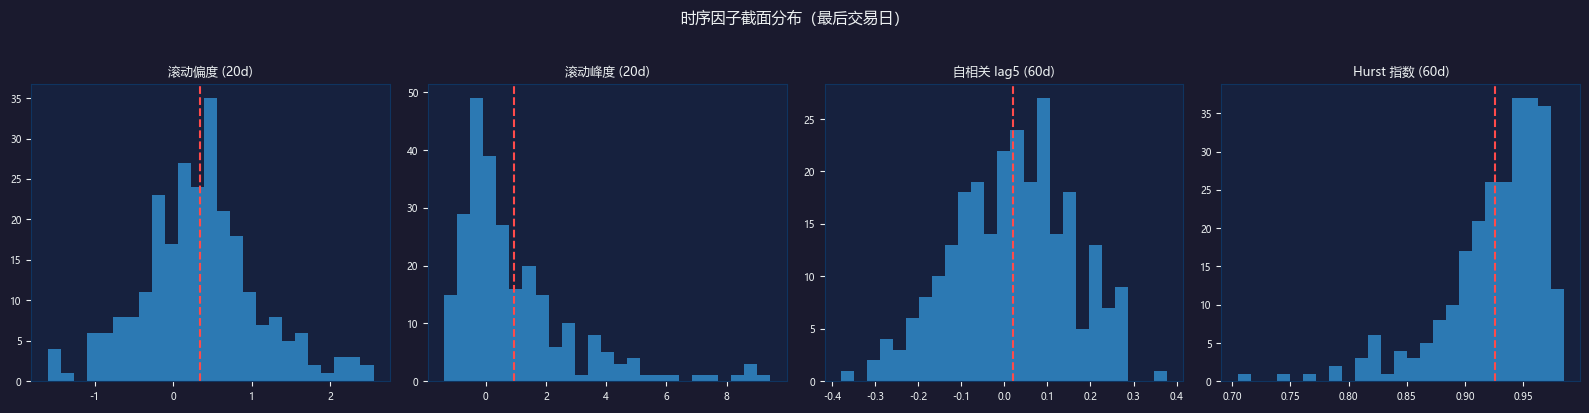

✅ 4 个时序因子验证通过


In [5]:
# 可视化：4 个时序因子的截面分布（最后一个交易日）
fig, axes = plt.subplots(1, 4, figsize=(16, 4), facecolor='#1A1A2E')
factor_pairs = [
    (f_skew,     '滚动偏度 (20d)'),
    (f_kurt,     '滚动峰度 (20d)'),
    (f_autocorr, '自相关 lag5 (60d)'),
    (f_hurst,    'Hurst 指数 (60d)'),
]
for ax, (f, title) in zip(axes, factor_pairs):
    ax.set_facecolor('#16213E')
    vals = f.iloc[-1].dropna().values
    ax.hist(vals, bins=25, color='#3498DB', alpha=0.75, edgecolor='none')
    ax.set_title(title, color='#ECF0F1', fontsize=9)
    ax.tick_params(colors='#ECF0F1', labelsize=7)
    for sp in ax.spines.values(): sp.set_color('#0F3460')
    ax.axvline(np.nanmean(vals), color='#FF4B4B', linewidth=1.5, linestyle='--')

fig.suptitle('时序因子截面分布（最后交易日）', color='#ECF0F1', fontsize=11, y=1.02)
plt.tight_layout()
plt.show()
print('✅ 4 个时序因子验证通过')

## §4. 新增量价因子

| 算子 | 原理 | 含义 |
|------|------|------|
| `VWAP(close, volume, window)` | Σ(P×V)/ΣV | 滚动成交量加权均价，反映真实成本 |
| `VWAP_Bias(close, volume, window)` | Close/VWAP − 1 | VWAP 乖离率：价格偏离 VWAP 的百分比（均值回归/动量信号）|
| `PVDeviation(close, volume, window)` | (close − VWAP) / σ | 价格偏离 VWAP 的标准化程度（无量纲）|
| `Amihud(close, volume, window)` | mean(\|ret\|/volume) | 非流动性指标：单位成交量对应的价格冲击 |

In [6]:
# ── VWAP：成交量加权均价 ──────────────────────────────────────
f_vwap = op.VWAP(close, volume, window=10)
print('VWAP(close, volume, 10)')
print(f'  所有 VWAP > 0: {(f_vwap > 0).all().all()}')
# VWAP 与 close 的比值应接近 1
ratio = (close / f_vwap).stack().dropna()
print(f'  close/VWAP 均值: {ratio.mean():.4f}  (应接近 1.0)')

# ── VWAP_Bias：VWAP 乖离率 ──────────────────────────────────
f_vwap_bias = op.VWAP_Bias(close, volume, window=10)
bias_vals = f_vwap_bias.stack().dropna()
print('\nVWAP_Bias(close, volume, 10)')
print(f'  均值: {bias_vals.mean():.6f}  (应接近 0)')
print(f'  典型范围 [P5, P95]: [{bias_vals.quantile(0.05):.4f}, {bias_vals.quantile(0.95):.4f}]')
print(f'  正值比例(价格>VWAP): {(bias_vals > 0).mean()*100:.1f}%')

# 演示两种信号用法
print('\n  → 均值回归信号（大幅低于VWAP → 反弹）:  op.Rank(-f_vwap_bias)')
print('  → 趋势跟踪信号（持续高于VWAP → 动量）:  op.Rank(f_vwap_bias)')
f_bias_rev = op.Rank(-f_vwap_bias)   # 均值回归
f_bias_mom = op.Rank(f_vwap_bias)    # 趋势跟踪
print(f'  均值回归因子值域 (均值): {f_bias_rev.stack().dropna().mean():.4f}')

# ── PVDeviation：价格偏离度 ──────────────────────────────────
f_pvdev = op.PVDeviation(close, volume, window=10)
pvdev_vals = f_pvdev.stack().dropna()
print('\nPVDeviation(close, volume, 10)')
print(f'  均值: {pvdev_vals.mean():.4f}  标准差: {pvdev_vals.std():.4f}')
print(f'\n  VWAP_Bias vs PVDeviation 相关性: '
      f'{f_vwap_bias.stack().dropna().corr(f_pvdev.stack().dropna()):.4f}'
      f'  (高相关但信息互补，量纲不同)')

# ── Amihud：非流动性 ──────────────────────────────────────────
f_amihud = op.Amihud(close, volume, window=20)
amihud_vals = f_amihud.stack().dropna()
print('\nAmihud(close, volume, 20)')
print(f'  中位数: {amihud_vals.median():.2e}  最大值: {amihud_vals.quantile(0.99):.2e}')

print('\n✅ 4 个量价因子验证通过')

VWAP(close, volume, 10)
  所有 VWAP > 0: False
  close/VWAP 均值: 1.0002  (应接近 1.0)

VWAP_Bias(close, volume, 10)
  均值: 0.000203  (应接近 0)
  典型范围 [P5, P95]: [-0.0464, 0.0511]
  正值比例(价格>VWAP): 47.8%

  → 均值回归信号（大幅低于VWAP → 反弹）:  op.Rank(-f_vwap_bias)
  → 趋势跟踪信号（持续高于VWAP → 动量）:  op.Rank(f_vwap_bias)
  均值回归因子值域 (均值): 0.5019

PVDeviation(close, volume, 10)
  均值: -0.0703  标准差: 1.1487

  VWAP_Bias vs PVDeviation 相关性: 0.7968  (高相关但信息互补，量纲不同)

Amihud(close, volume, 20)
  中位数: 3.25e-10  最大值: 6.65e-09

✅ 4 个量价因子验证通过


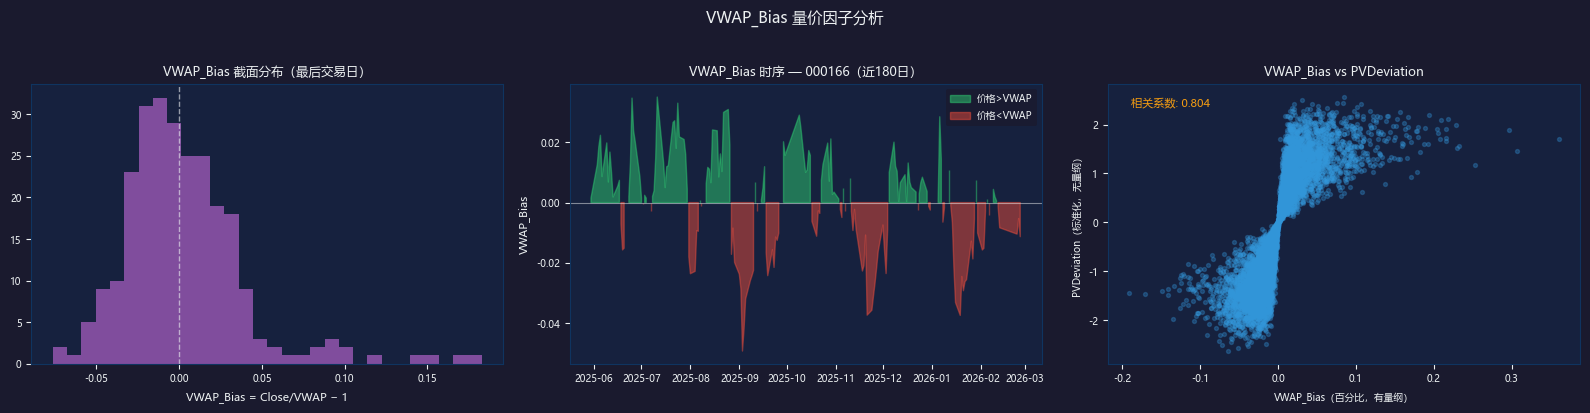

✅ VWAP_Bias 可视化完成


In [7]:
# 可视化：VWAP_Bias 截面分布 + 时序走势（单只股票示例）
stock_ex = close.columns[5]
date_slice = slice(-180, None)   # 最近 180 交易日
idx_vis = close.index[date_slice]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), facecolor='#1A1A2E')

# 左：截面分布（最后一日）
ax0 = axes[0]
ax0.set_facecolor('#16213E')
last_bias = f_vwap_bias.iloc[-1].dropna().values
ax0.hist(last_bias, bins=30, color='#9B59B6', alpha=0.8, edgecolor='none')
ax0.axvline(0, color='#ECF0F1', linewidth=1.0, alpha=0.6, linestyle='--')
ax0.set_title('VWAP_Bias 截面分布（最后交易日）', color='#ECF0F1', fontsize=9)
ax0.set_xlabel('VWAP_Bias = Close/VWAP − 1', color='#ECF0F1', fontsize=8)
ax0.tick_params(colors='#ECF0F1', labelsize=7)
for sp in ax0.spines.values(): sp.set_color('#0F3460')

# 中：单只股票 VWAP_Bias 时序（对照收盘价填色）
ax1 = axes[1]
ax1.set_facecolor('#16213E')
bias_ts = f_vwap_bias.loc[idx_vis, stock_ex]
ax1.fill_between(idx_vis, bias_ts.values, 0,
                 where=(bias_ts.values >= 0), color='#2ECC71', alpha=0.5, label='价格>VWAP')
ax1.fill_between(idx_vis, bias_ts.values, 0,
                 where=(bias_ts.values < 0),  color='#E74C3C', alpha=0.5, label='价格<VWAP')
ax1.axhline(0, color='#ECF0F1', linewidth=0.8, alpha=0.5)
ax1.set_title(f'VWAP_Bias 时序 — {stock_ex}（近180日）', color='#ECF0F1', fontsize=9)
ax1.set_ylabel('VWAP_Bias', color='#ECF0F1', fontsize=8)
ax1.legend(fontsize=7, facecolor='#1A1A2E', edgecolor='none', labelcolor='#ECF0F1')
ax1.tick_params(colors='#ECF0F1', labelsize=7)
for sp in ax1.spines.values(): sp.set_color('#0F3460')

# 右：VWAP_Bias vs PVDeviation 散点（验证信息互补）
ax2 = axes[2]
ax2.set_facecolor('#16213E')
x_scat = f_vwap_bias.iloc[-30:].stack().dropna().values
y_scat = f_pvdev.iloc[-30:].stack().dropna()
# 对齐索引
xy = pd.concat([f_vwap_bias.iloc[-30:].stack().rename('bias'),
                f_pvdev.iloc[-30:].stack().rename('pvdev')], axis=1).dropna()
ax2.scatter(xy['bias'].values, xy['pvdev'].values,
            c='#3498DB', alpha=0.3, s=8)
ax2.set_title('VWAP_Bias vs PVDeviation', color='#ECF0F1', fontsize=9)
ax2.set_xlabel('VWAP_Bias（百分比，有量纲）', color='#ECF0F1', fontsize=7)
ax2.set_ylabel('PVDeviation（标准化，无量纲）', color='#ECF0F1', fontsize=7)
ax2.tick_params(colors='#ECF0F1', labelsize=7)
for sp in ax2.spines.values(): sp.set_color('#0F3460')
# 添加相关系数标注
corr_val = xy['bias'].corr(xy['pvdev'])
ax2.text(0.05, 0.92, f'相关系数: {corr_val:.3f}',
         transform=ax2.transAxes, color='#F39C12', fontsize=8)

plt.suptitle('VWAP_Bias 量价因子分析', color='#ECF0F1', fontsize=11, y=1.02)
plt.tight_layout()
plt.show()
print('✅ VWAP_Bias 可视化完成')

## §5. 新增动量因子

| 算子 | 原理 | 含义 |
|------|------|------|
| `RiskAdjMomentum(close, window, vol_window)` | CumRet / RolVol | 风险调整动量：单位波动率下的累计涨幅 |
| `PricePathQuality(close, window)` | \|Spearman\| × Pearson² | 路径质量：趋势单调且线性，值域 [0,1] |
| `RangeBreakout(close, high, low, window)` | (close-RolMin)/(RolMax-RolMin) | 相对价格区间位置，值域 [0,1] |

In [8]:
# ── RiskAdjMomentum：风险调整动量 ────────────────────────────
f_ram = op.RiskAdjMomentum(close, window=20, vol_window=10)
print('RiskAdjMomentum(close, 20, 10)')
print(f'  典型范围 [P1, P99]: [{f_ram.stack().dropna().quantile(0.01):.2f}, {f_ram.stack().dropna().quantile(0.99):.2f}]')

# ── PricePathQuality：路径质量因子 ────────────────────────────
f_ppq = op.PricePathQuality(close, window=20)
ppq_vals = f_ppq.stack().dropna()
print('\nPricePathQuality(close, 20)')
print(f'  值域验证 [0,1] 占比: {ppq_vals.between(0, 1).mean()*100:.1f}%')
print(f'  均值: {ppq_vals.mean():.4f}  （高=强趋势，低=震荡）')

# ── RangeBreakout：区间突破因子 ──────────────────────────────
f_rb = op.RangeBreakout(close, high, low, window=20)
rb_vals = f_rb.stack().dropna()
print('\nRangeBreakout(close, high, low, 20)')
print(f'  值域验证 [0,1] 占比: {rb_vals.between(0, 1).mean()*100:.1f}%')
print(f'  均值: {rb_vals.mean():.4f}  （>0.5=偏强势，<0.5=偏弱势）')

print('\n✅ 3 个动量因子验证通过')

RiskAdjMomentum(close, 20, 10)
  典型范围 [P1, P99]: [-12.73, 11.83]

PricePathQuality(close, 20)
  值域验证 [0,1] 占比: 100.0%
  均值: 0.3173  （高=强趋势，低=震荡）

RangeBreakout(close, high, low, 20)
  值域验证 [0,1] 占比: 100.0%
  均值: 0.4721  （>0.5=偏强势，<0.5=偏弱势）

✅ 3 个动量因子验证通过


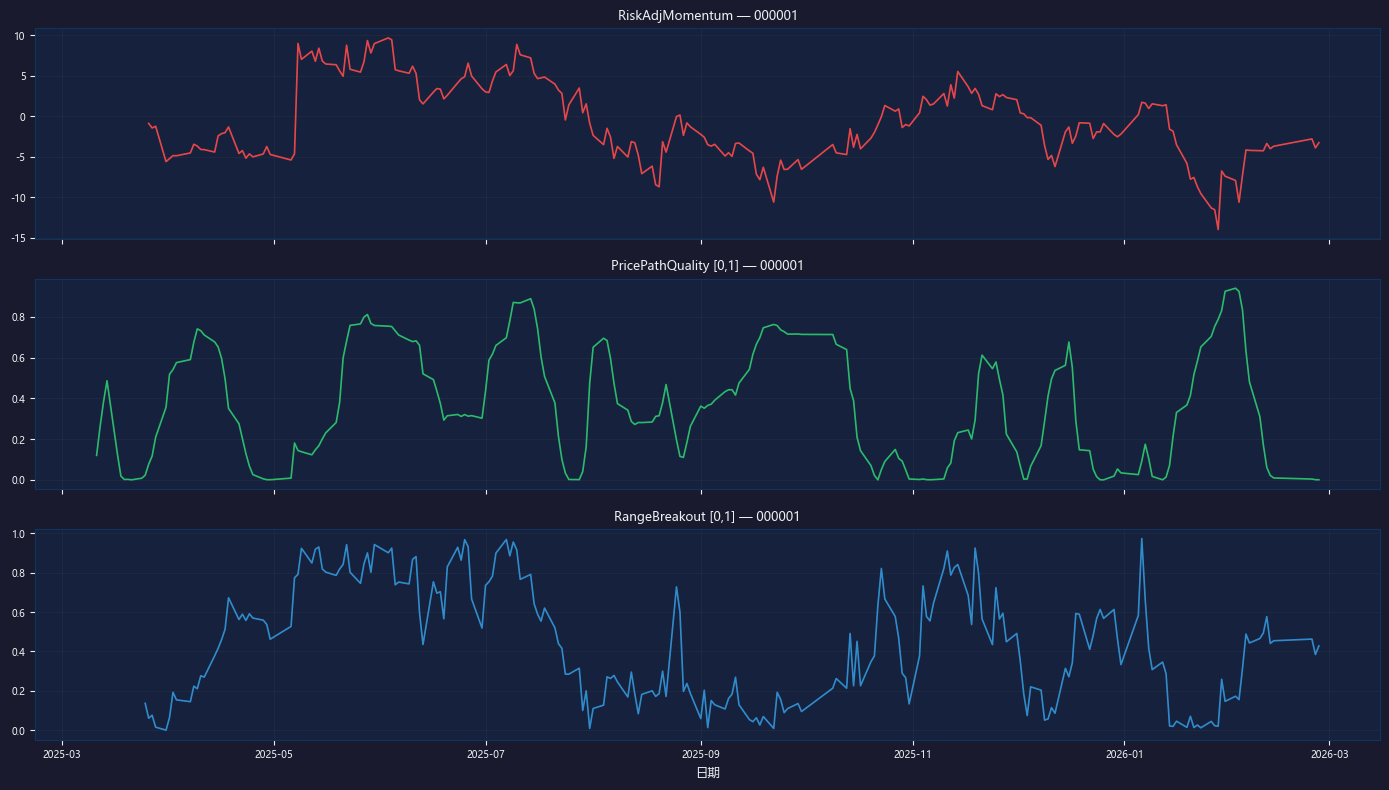

In [9]:
# 可视化：3 个动量因子时序（单只股票示例）
stock_ex = close.columns[0]

fig, axes = plt.subplots(3, 1, figsize=(14, 8), facecolor='#1A1A2E', sharex=True)
plot_data = [
    (f_ram[stock_ex], 'RiskAdjMomentum', '#FF4B4B'),
    (f_ppq[stock_ex], 'PricePathQuality [0,1]', '#2ECC71'),
    (f_rb[stock_ex],  'RangeBreakout [0,1]', '#3498DB'),
]
for ax, (series, title, color) in zip(axes, plot_data):
    ax.set_facecolor('#16213E')
    ax.plot(series.index, series.values, color=color, linewidth=1.2, alpha=0.9)
    ax.set_title(f'{title} — {stock_ex}', color='#ECF0F1', fontsize=9)
    ax.tick_params(colors='#ECF0F1', labelsize=7)
    ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
    for sp in ax.spines.values(): sp.set_color('#0F3460')

axes[-1].set_xlabel('日期', color='#ECF0F1', fontsize=9)
plt.tight_layout()
plt.show()

## §6. 新增技术指标

| 算子 | 原理 | 输出含义 |
|------|------|----------|
| `RSI(close, window=14)` | Wilder EWM 平滑 | 值域 [0,100]，>70 超买，<30 超卖 |
| `KDJ(close, high, low, n=9, m1=3, m2=3)` | RSV + EWM | 返回 K 值（0~100），惯性指标 |
| `MACD(close, fast=12, slow=26, signal=9)` | 双 EMA 差 | 柱状图（MACD 线 - 信号线），穿零轴为交叉信号 |

In [10]:
# ── RSI：相对强弱指标 ─────────────────────────────────────────
f_rsi = op.RSI(close, window=14)
rsi_vals = f_rsi.stack().dropna()
print('RSI(close, 14)')
print(f'  值域验证 [0,100] 占比: {rsi_vals.between(0, 100).mean()*100:.1f}%')
print(f'  超买(>70): {(rsi_vals>70).mean()*100:.1f}%  超卖(<30): {(rsi_vals<30).mean()*100:.1f}%')

# ── KDJ：随机指标 K 值 ────────────────────────────────────────
f_kdj = op.KDJ(close, high, low, n=9, m1=3, m2=3)
kdj_vals = f_kdj.stack().dropna()
print('\nKDJ(close, high, low, n=9, m1=3, m2=3)  → K 值')
print(f'  均值: {kdj_vals.mean():.2f}  中位数: {kdj_vals.median():.2f}  (中性=50)')

# ── MACD：指数平滑移动平均 ────────────────────────────────────
f_macd = op.MACD(close, fast=12, slow=26, signal=9)
macd_vals = f_macd.stack().dropna()
print('\nMACD(close, fast=12, slow=26, signal=9)  → 柱状图')
print(f'  均值接近0: {macd_vals.mean():.4f}  标准差: {macd_vals.std():.4f}')
print(f'  正值(多头): {(macd_vals>0).mean()*100:.1f}%')

print('\n✅ 3 个技术指标验证通过')

RSI(close, 14)
  值域验证 [0,100] 占比: 100.0%
  超买(>70): 7.0%  超卖(<30): 4.8%

KDJ(close, high, low, n=9, m1=3, m2=3)  → K 值
  均值: 47.25  中位数: 47.58  (中性=50)

MACD(close, fast=12, slow=26, signal=9)  → 柱状图
  均值接近0: 0.0138  标准差: 1.3298
  正值(多头): 52.8%

✅ 3 个技术指标验证通过


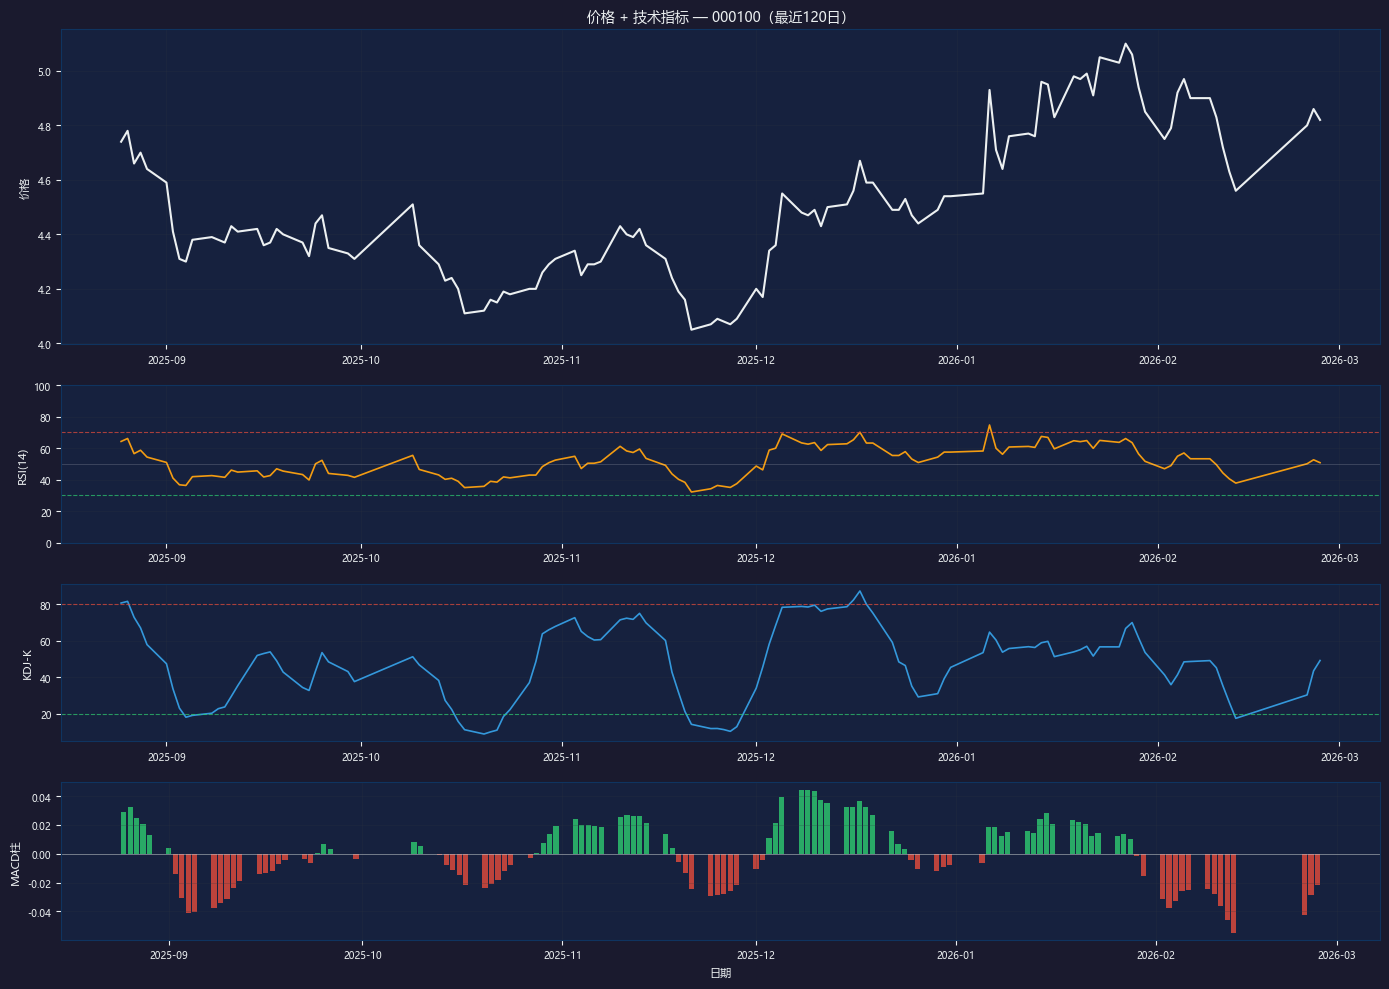

In [11]:
# 可视化：技术指标（单只股票，对照价格图）
stock_ex = close.columns[3]
date_slice = slice(-120, None)  # 最近 120 交易日

fig, axes = plt.subplots(4, 1, figsize=(14, 10), facecolor='#1A1A2E',
                          gridspec_kw={'height_ratios': [3, 1.5, 1.5, 1.5]})

idx = close.index[date_slice]

# 价格
ax0 = axes[0]
ax0.set_facecolor('#16213E')
ax0.plot(idx, close.loc[idx, stock_ex], color='#ECF0F1', linewidth=1.5)
ax0.set_title(f'价格 + 技术指标 — {stock_ex}（最近120日）', color='#ECF0F1', fontsize=10)
ax0.set_ylabel('价格', color='#ECF0F1', fontsize=8)

# RSI
ax1 = axes[1]
ax1.set_facecolor('#16213E')
rsi_s = f_rsi.loc[idx, stock_ex]
ax1.plot(idx, rsi_s, color='#F39C12', linewidth=1.2)
ax1.axhline(70, color='#E74C3C', linewidth=0.8, linestyle='--', alpha=0.7)
ax1.axhline(30, color='#2ECC71', linewidth=0.8, linestyle='--', alpha=0.7)
ax1.axhline(50, color='#ECF0F1', linewidth=0.4, alpha=0.3)
ax1.set_ylabel('RSI(14)', color='#ECF0F1', fontsize=8)
ax1.set_ylim(0, 100)

# KDJ K 值
ax2 = axes[2]
ax2.set_facecolor('#16213E')
ax2.plot(idx, f_kdj.loc[idx, stock_ex], color='#3498DB', linewidth=1.2)
ax2.axhline(80, color='#E74C3C', linewidth=0.8, linestyle='--', alpha=0.7)
ax2.axhline(20, color='#2ECC71', linewidth=0.8, linestyle='--', alpha=0.7)
ax2.set_ylabel('KDJ-K', color='#ECF0F1', fontsize=8)

# MACD 柱
ax3 = axes[3]
ax3.set_facecolor('#16213E')
macd_s = f_macd.loc[idx, stock_ex]
colors_m = ['#2ECC71' if v >= 0 else '#E74C3C' for v in macd_s.values]
ax3.bar(idx, macd_s.values, color=colors_m, alpha=0.8, width=0.8)
ax3.axhline(0, color='#ECF0F1', linewidth=0.6, alpha=0.5)
ax3.set_ylabel('MACD柱', color='#ECF0F1', fontsize=8)
ax3.set_xlabel('日期', color='#ECF0F1', fontsize=8)

for ax in axes:
    ax.tick_params(colors='#ECF0F1', labelsize=7)
    ax.grid(True, color='#2F3640', alpha=0.4, linewidth=0.4)
    for sp in ax.spines.values(): sp.set_color('#0F3460')

plt.tight_layout()
plt.show()

## §7. Labeler — 前向收益率标签生成

`Labeler` 用于为多因子融合生成监督学习所需的 **前向收益率标签 Y**。

支持两种模式：
- **内置预设**：从价格矩阵自动计算前向收益率
- **自定义**：直接传入 `custom_label` DataFrame（优先级更高）

In [14]:
from quant_alpha_engine.fusion import Labeler
lb = Labeler()

# ── 模式一：内置预设 - 5 日简单收益率 ────────────────────────
y5 = lb.set_label(
    target  = 'close',
    horizon = 5,
    method  = 'return',
    data    = {'close': close},
)
print('内置预设 - 5日简单收益率:')
print(f'  形状: {y5.shape}  末尾 NaN 行数: {y5.isna().all(axis=1).sum()}')

# ── 模式二：内置预设 - 1 日对数收益率 ────────────────────────
y1_log = lb.set_label(
    target  = 'close',
    horizon = 1,
    method  = 'log_return',
    data    = {'close': close},
)
print('\n内置预设 - 1日对数收益率:')
print(f'  均值: {y1_log.stack().dropna().mean():.6f}  std: {y1_log.stack().dropna().std():.4f}')

# ── 模式三：自定义标签 ────────────────────────────────────────
my_y = (close.shift(-3) / close - 1)   # 手工构造 3 日收益率
y_custom = lb.set_label(custom_label=my_y)
print('\n自定义标签:')
print(f'  与输入完全一致: {y_custom.equals(my_y)}')

# ── 静态便捷方法 ──────────────────────────────────────────────
y_static = Labeler.from_price(close, horizon=5)
print('\n静态便捷方法 Labeler.from_price(close, 5):')
print(f'  形状: {y_static.shape}')

print('\n✅ Labeler 所有模式验证通过')

# 后续使用 5 日收益率作为主标签
y = y5

内置预设 - 5日简单收益率:
  形状: (243, 257)  末尾 NaN 行数: 5

内置预设 - 1日对数收益率:
  均值: 0.000548  std: 0.0217

自定义标签:
  与输入完全一致: True

静态便捷方法 Labeler.from_price(close, 5):
  形状: (243, 257)

✅ Labeler 所有模式验证通过


## §8. StatisticalCombiner — 统计多因子融合

用 3 种权重方式把多个因子合成一个复合因子：

| method | 权重计算 | 适用场景 |
|--------|---------|----------|
| `'equal'` | 等权 1/K | 简单基准，快速验证 |
| `'ic_weighted'` | 按 IC 均值加权 | 让预测力更强的因子获得更高权重 |
| `'min_variance'` | SLSQP 最小方差 | 最小化合成因子噪声（适合高相关因子组合）|

In [15]:
# ── 回测公共配置 ──────────────────────────────────────────────────
# 修改这里即可统一影响下方所有回测（单因子 + 融合器 evaluate 均生效）
REBALANCE_FREQ = 5        # 调仓频率：5 = 每周
TOP_N          = 30       # 持仓股数
WEIGHT_METHOD  = 'equal'  # 'equal' | 'factor_weighted'
COST_RATE      = 0.0015   # 单边交易成本（0.15%）

# ── 预处理参数（v2.0）────────────────────────────────────────────
# delay=d 的语义：用 T-d 日因子预测 T 日收益
# delay=1（推荐）：T-1 日因子 → T 日建仓 → 赚 T 日收益，严格无未来函数
# delay=0：T 日因子预测 T 日收益，存在 look-ahead bias，仅供研究对比
# 本 notebook 因子已在外部完成 Rank 等处理，但仍建议保持 delay=1
DELAY    = 1     # 1 = T-1日因子预测T日收益（标准配置，推荐）
DECAY    = 0     # 0 = 不衰减；>0 = Decay_Linear 平滑窗口
INDUSTRY = industry  # None = 不做行业中性化；传入 industry Series = OLS中性化

# ── 回测时间范围控制（v2.1）──────────────────────────────────────
# None = 使用全部数据；填入日期字符串 = 仅评估指定区间
# 注意：仅裁剪回测评估区间，不影响因子历史窗口的计算
START_DATE = None  # 回测开始日期，如 '2022-06-01'
END_DATE   = None  # 回测结束日期，如 '2023-12-31'

print(f'回测配置：rebalance_freq={REBALANCE_FREQ}, top_n={TOP_N}, '
      f'weight={WEIGHT_METHOD}, cost={COST_RATE}')
print(f'预处理：delay={DELAY}（T-{DELAY}日因子预测T日收益）, '
      f'decay={DECAY}, industry={INDUSTRY}')
print(f'时间范围：{START_DATE} ~ {END_DATE}  (None = 不限制)')

回测配置：rebalance_freq=5, top_n=30, weight=equal, cost=0.0015
预处理：delay=1（T-1日因子预测T日收益）, decay=0, industry=stock
000001      银行
000002     房地产
000063      通信
000100      电子
000157    机械设备
          ... 
688256      电子
688271    医药生物
688472    电力设备
688506    医药生物
688599    电力设备
Name: industry, Length: 257, dtype: object
时间范围：None ~ None  (None = 不限制)


In [16]:
# 准备 3 个候选因子（使用新算子构造，覆盖不同信号维度）
print('构造候选因子...')
f1 = op.Rank(-op.Ts_Delta(close, 5))                          # 短期反转
f2 = op.Rank(f_rsi.rsub(50).abs().mul(-1))                    # RSI 距离中性区域
f3 = op.Rank(op.RiskAdjMomentum(close, window=20, vol_window=10))  # 风险调整动量
factors = [f1, f2, f3]
factor_names = ['短期反转', 'RSI中性距', '风险调整动量']
print('✅ 因子构造完成')

构造候选因子...
✅ 因子构造完成


In [18]:
# ── 等权融合 ──────────────────────────────────────────────────
from quant_alpha_engine.fusion import StatisticalCombiner
stat_equal = StatisticalCombiner(method='equal')
stat_equal.fit(factors, label=y)
print(f'Equal 权重: {stat_equal.weights_}')

# ── IC 加权融合 ────────────────────────────────────────────────
stat_ic = StatisticalCombiner(method='ic_weighted')
stat_ic.fit(factors, label=y)
print(f'IC加权权重: {np.round(stat_ic.weights_, 4)}')
print(f'IC 矩阵形状: {stat_ic.ic_matrix_.shape}  均值:')
for i, name in enumerate(factor_names):
    print(f'  {name}: IC均值 = {stat_ic.ic_matrix_.iloc[:, i].mean():+.4f}')

# ── 最小方差融合 ──────────────────────────────────────────────
stat_mv = StatisticalCombiner(method='min_variance')
stat_mv.fit(factors, label=y)
print(f'\n最小方差权重: {np.round(stat_mv.weights_, 4)}')

Equal 权重: [0.33333333 0.33333333 0.33333333]
IC加权权重: [0.1779 0.2289 0.5931]
IC 矩阵形状: (233, 3)  均值:
  短期反转: IC均值 = +0.0056
  RSI中性距: IC均值 = +0.0072
  风险调整动量: IC均值 = +0.0185

最小方差权重: [0.3759 0.2213 0.4028]


In [19]:
# 使用 IC 加权融合器进行完整回测
print('=' * 55)
print('  StatisticalCombiner (ic_weighted) 回测')
print('=' * 55)

result_stat = stat_ic.evaluate(
    factors        = factors,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,      # combiner 输出已是合成信号，通常不需额外延迟
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result_stat.print_summary()

  StatisticalCombiner (ic_weighted) 回测
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！



指标,数值,评价
年化收益率,+11.52%,较差
年化波动率,+15.06%,中风险
Sharpe Ratio,+0.7996,较差
Calmar Ratio,+1.1901,良好
最大回撤,-9.68%,良好
IC 均值,+0.0005,较差
IC 标准差,+0.1037,稳定
ICIR,+0.0701,较差
IC 胜率,+48.52%,较差
IC t-stat,+0.0679,


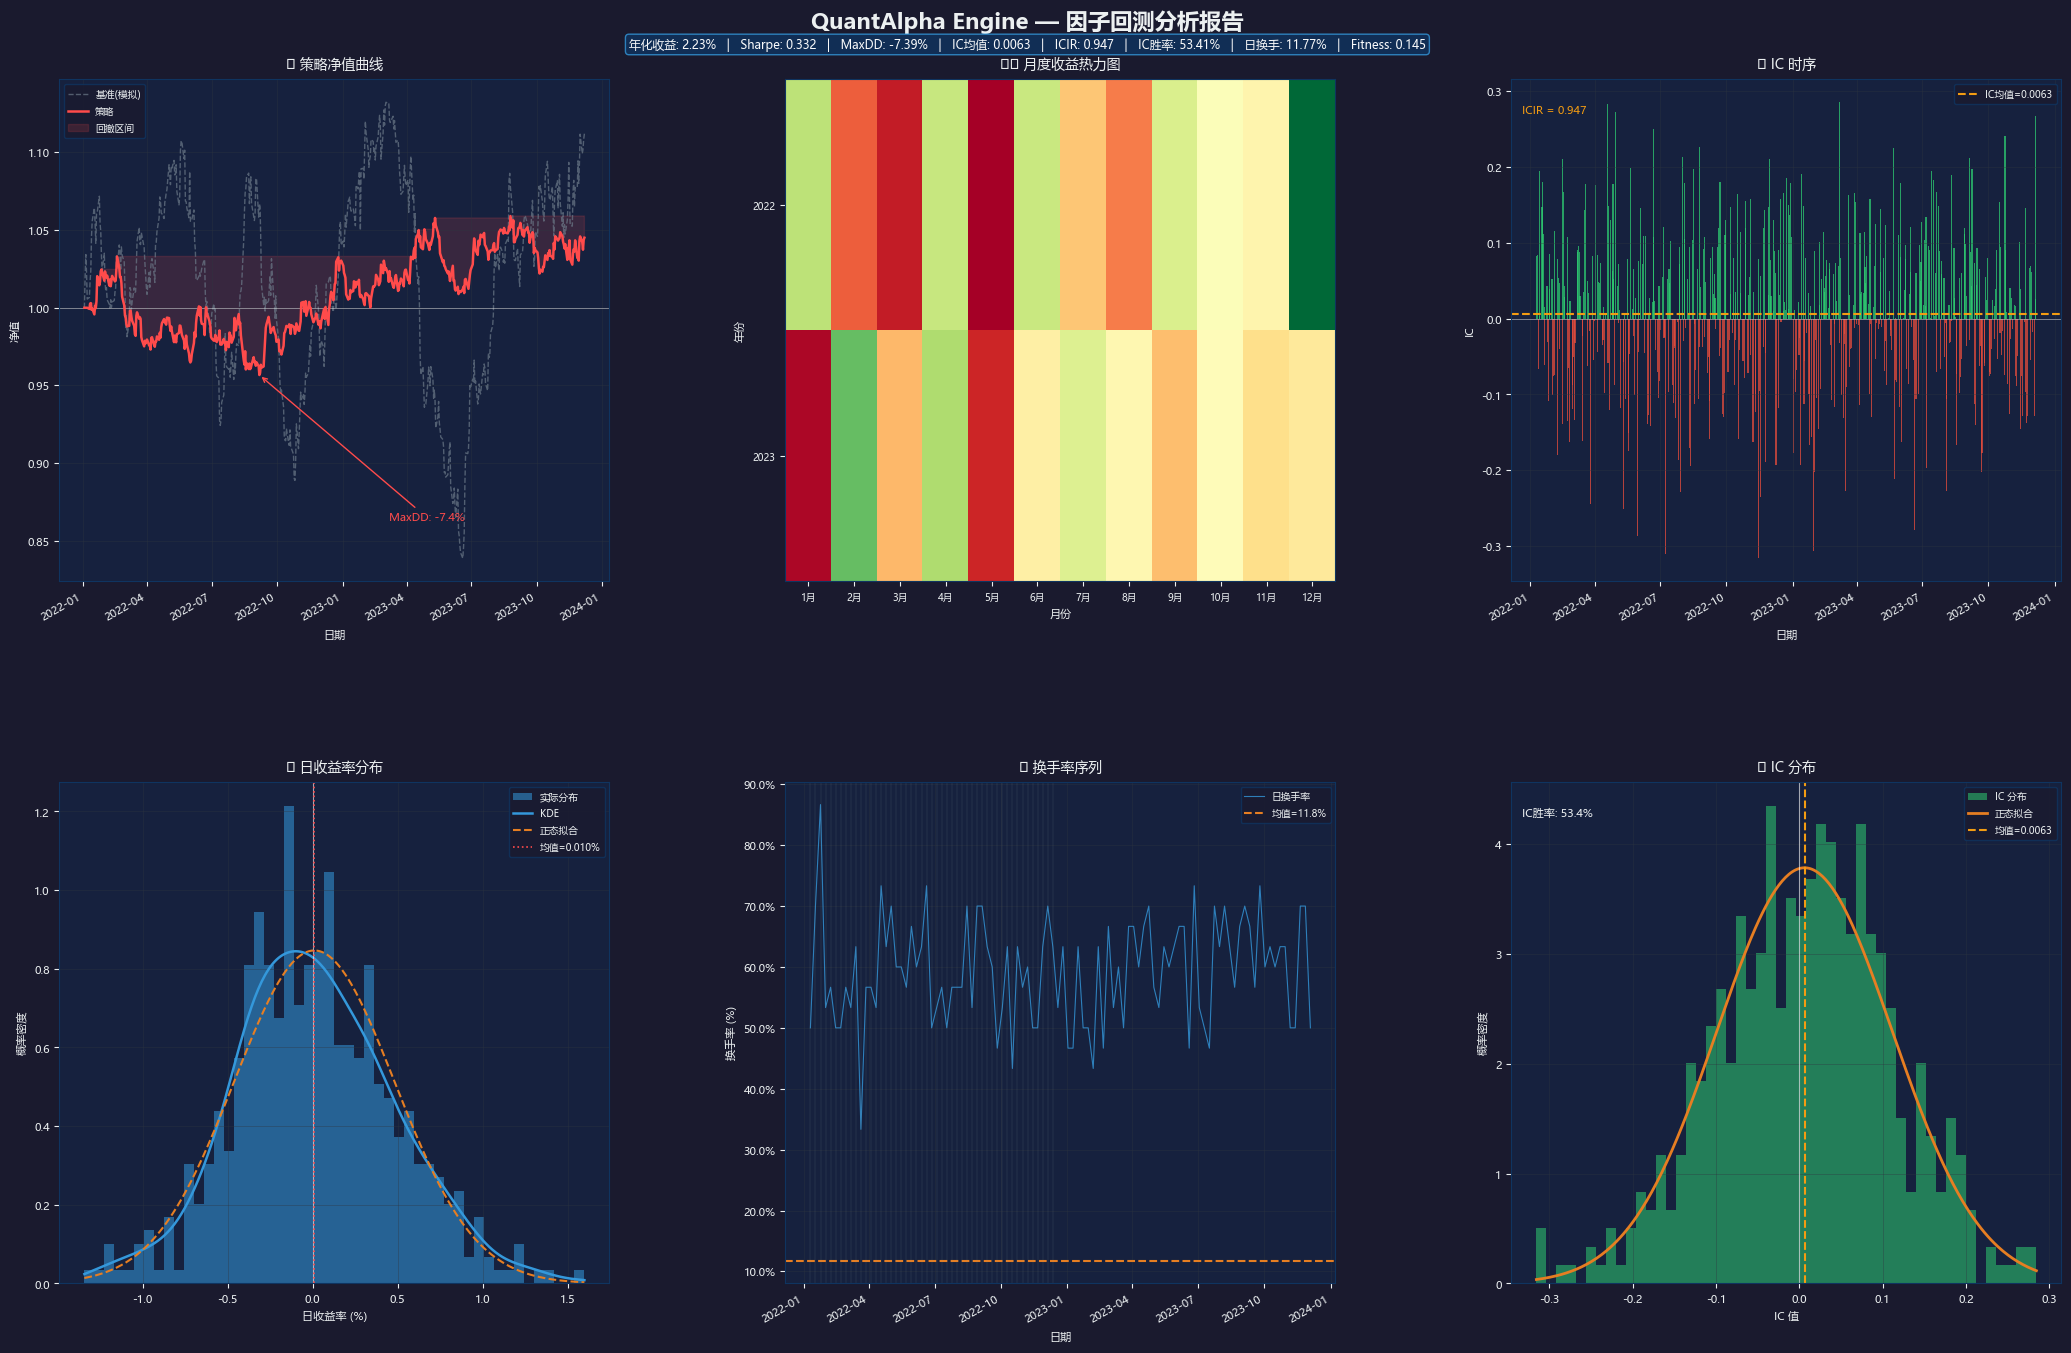

In [15]:
result_stat.plot()

## §9. MLCombiner — 机器学习融合

**核心设计：Expanding Window（严格防未来函数）**
```
Day  0~59   → NaN（积累期，不产生预测）
Day  60~79  → fit(train=[0,60))   → predict [60,80)
Day  80~99  → fit(train=[0,80))   → predict [80,100)
...（训练集持续扩大，预测集始终是「未来」）
```

支持 4 种模型：`'linear'` / `'ridge'` / `'random_forest'` / `'xgboost'`（需安装 xgboost）

In [20]:
from quant_alpha_engine.fusion import MLCombiner
# ── Ridge 回归融合（推荐，稳定、快速）────────────────────────
print('训练 Ridge MLCombiner...')
ml_ridge = MLCombiner(
    model_type        = 'ridge',
    min_train_periods = 60,    # 至少积累 60 天再开始预测
    refit_freq        = 20,    # 每 20 天重训一次
    ridge_alpha       = 1.0,
)
ml_ridge.fit(factors, label=y)

# 验证防未来函数：前 60 行必须全为 NaN
pred_ridge = ml_ridge.predict(factors)
assert pred_ridge.iloc[:60].isna().all().all(), '❌ 前60行应全为 NaN！'
print(f'✅ 防未来函数验证通过：前 {ml_ridge.min_train_periods} 行全为 NaN')
print(f'有效预测天数: {pred_ridge.notna().all(axis=1).sum()}')

# 特征重要性
print('\n特征重要性（Ridge |coef| 归一化）:')
for name, imp in zip(factor_names, ml_ridge.feature_importances_.values):
    bar = '█' * int(imp * 40)
    print(f'  {name:<12}: {bar:<40} {imp:.4f}')

训练 Ridge MLCombiner...
✅ 防未来函数验证通过：前 60 行全为 NaN
有效预测天数: 183

特征重要性（Ridge |coef| 归一化）:
  短期反转        : █████████                                0.2444
  RSI中性距      : ██                                       0.0700
  风险调整动量      : ███████████████████████████              0.6857


In [21]:
# ── 随机森林融合 ─────────────────────────────────────────────
print('训练 RandomForest MLCombiner...')
ml_rf = MLCombiner(
    model_type        = 'random_forest',
    min_train_periods = 60,
    refit_freq        = 30,
    rf_n_estimators   = 50,   # 演示用减少树数量以加快速度
    rf_max_depth      = 4,
)
ml_rf.fit(factors, label=y)
print(f'✅ 训练完成，共 {len(ml_rf._models)} 个子模型')

print('\n特征重要性（RF feature_importances_ 归一化）:')
for name, imp in zip(factor_names, ml_rf.feature_importances_.values):
    bar = '█' * int(imp * 40)
    print(f'  {name:<12}: {bar:<40} {imp:.4f}')

训练 RandomForest MLCombiner...
✅ 训练完成，共 8 个子模型

特征重要性（RF feature_importances_ 归一化）:
  短期反转        : ████████████                             0.3199
  RSI中性距      : ████████████                             0.3074
  风险调整动量      : ██████████████                           0.3727


In [25]:
# Ridge MLCombiner 完整回测
print('=' * 55)
print('  MLCombiner (Ridge, Expanding Window) 回测')
print('=' * 55)

result_ml = ml_ridge.evaluate(
    factors        = factors,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,      # MLCombiner expanding window 已防未来函数，无需延迟
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result_ml.print_summary()

  MLCombiner (Ridge, Expanding Window) 回测
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！



指标,数值,评价
年化收益率,+20.95%,良好
年化波动率,+13.08%,中风险
Sharpe Ratio,+1.5194,优秀
Calmar Ratio,+2.9949,优秀
最大回撤,-6.99%,良好
IC 均值,-0.0223,较差
IC 标准差,+0.0979,极稳定
ICIR,-3.6158,优秀
IC 胜率,+36.81%,较差
IC t-stat,-3.0728,


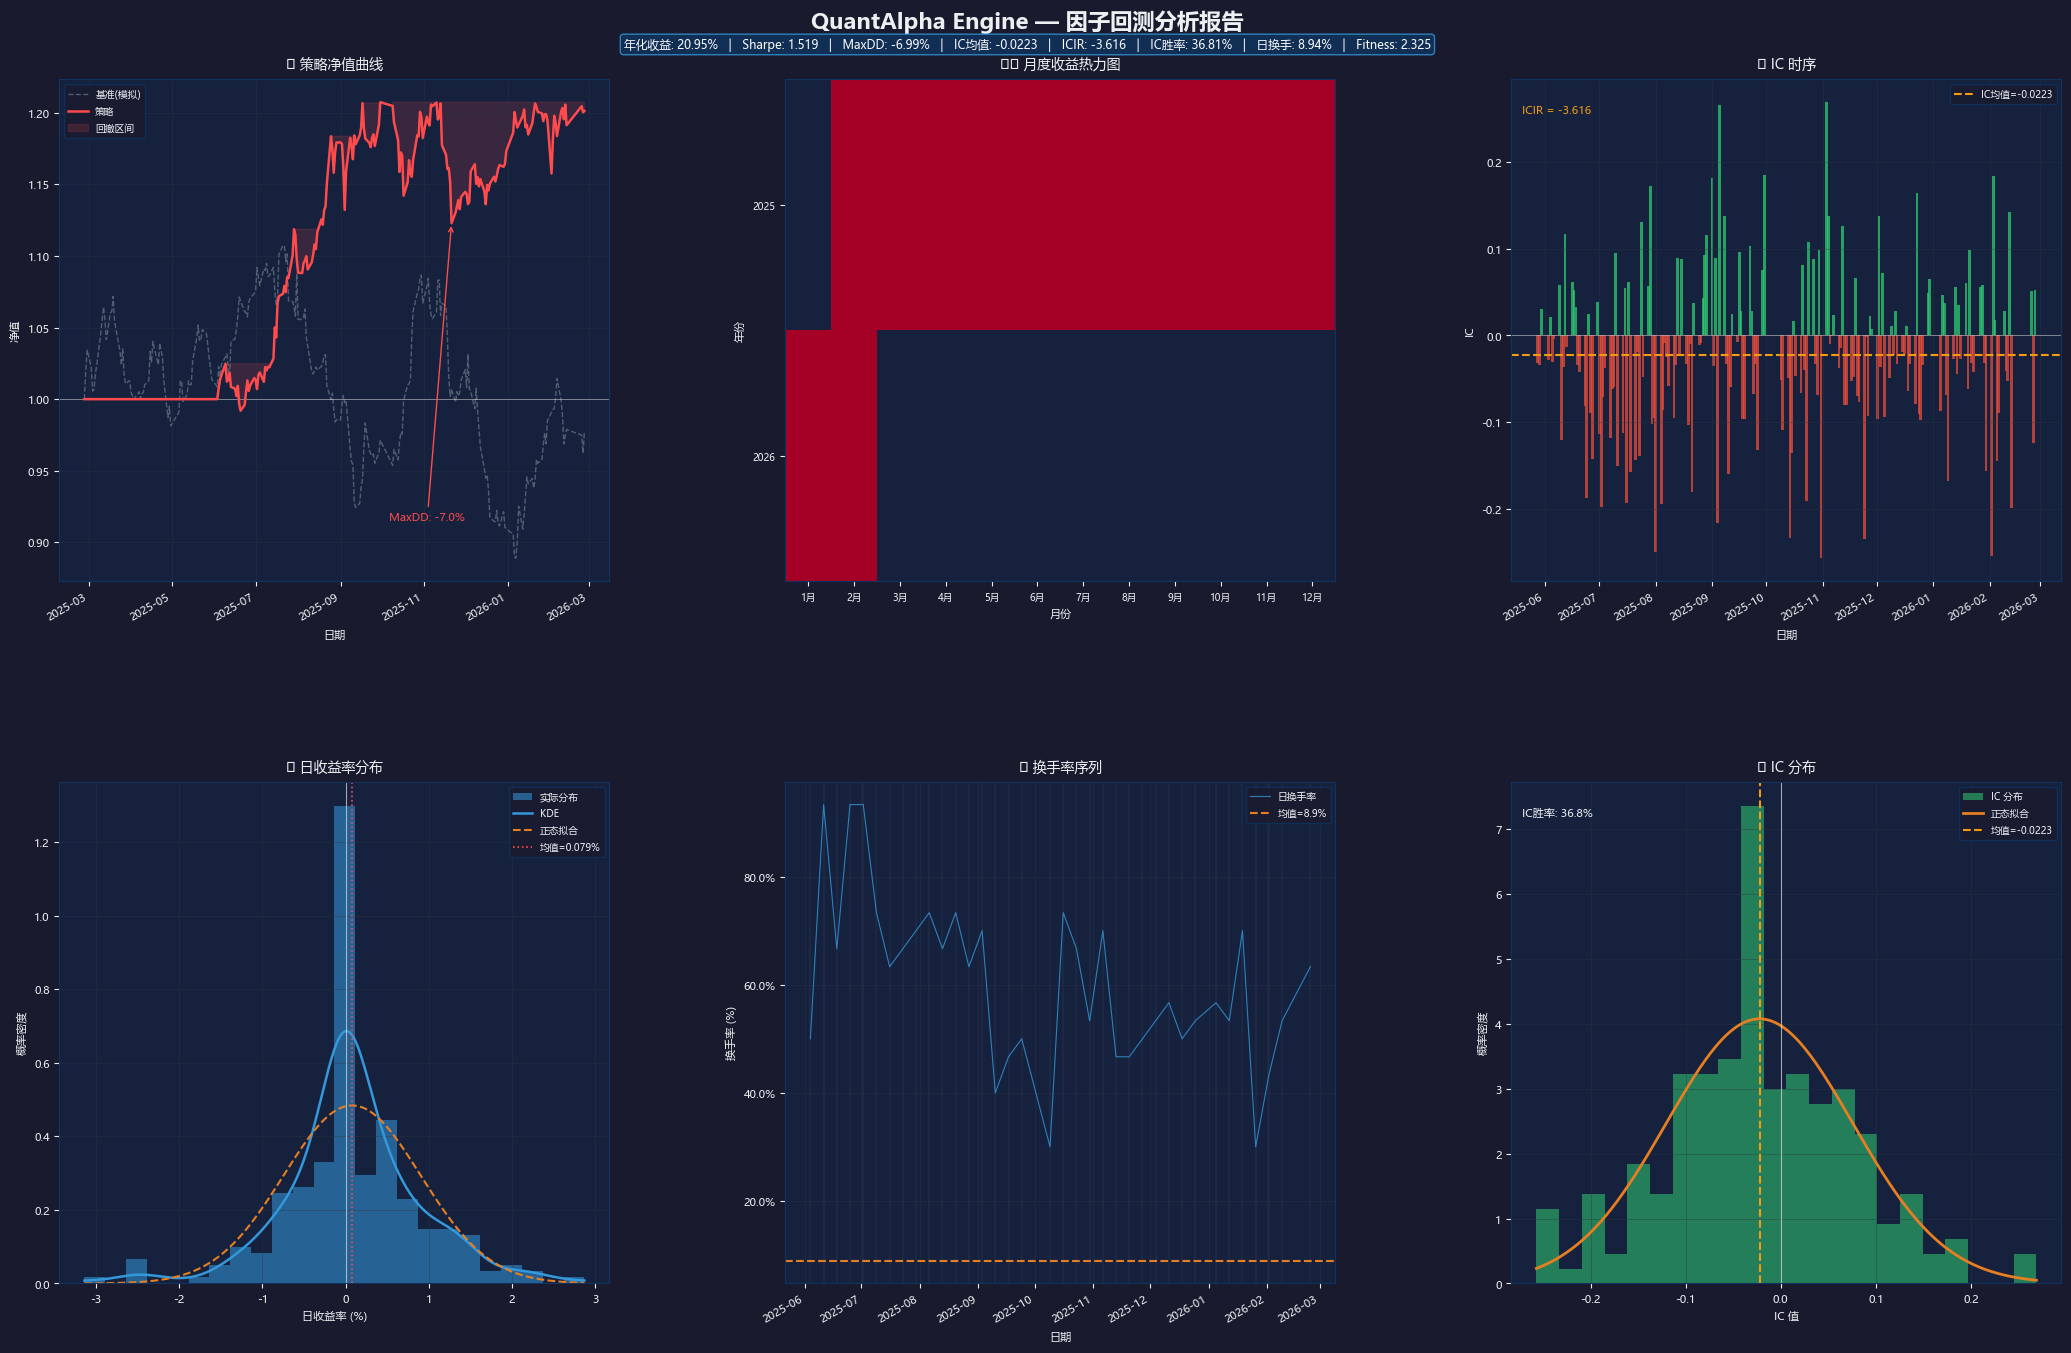

In [26]:
result_ml.plot()

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！



指标,数值,评价
年化收益率,+12.41%,较差
年化波动率,+12.50%,中风险
Sharpe Ratio,+0.9986,较差
Calmar Ratio,+1.5100,良好
最大回撤,-8.22%,良好
IC 均值,-0.0105,较差
IC 标准差,+0.0765,极稳定
ICIR,-2.1742,良好
IC 胜率,+42.86%,较差
IC t-stat,-1.8477,


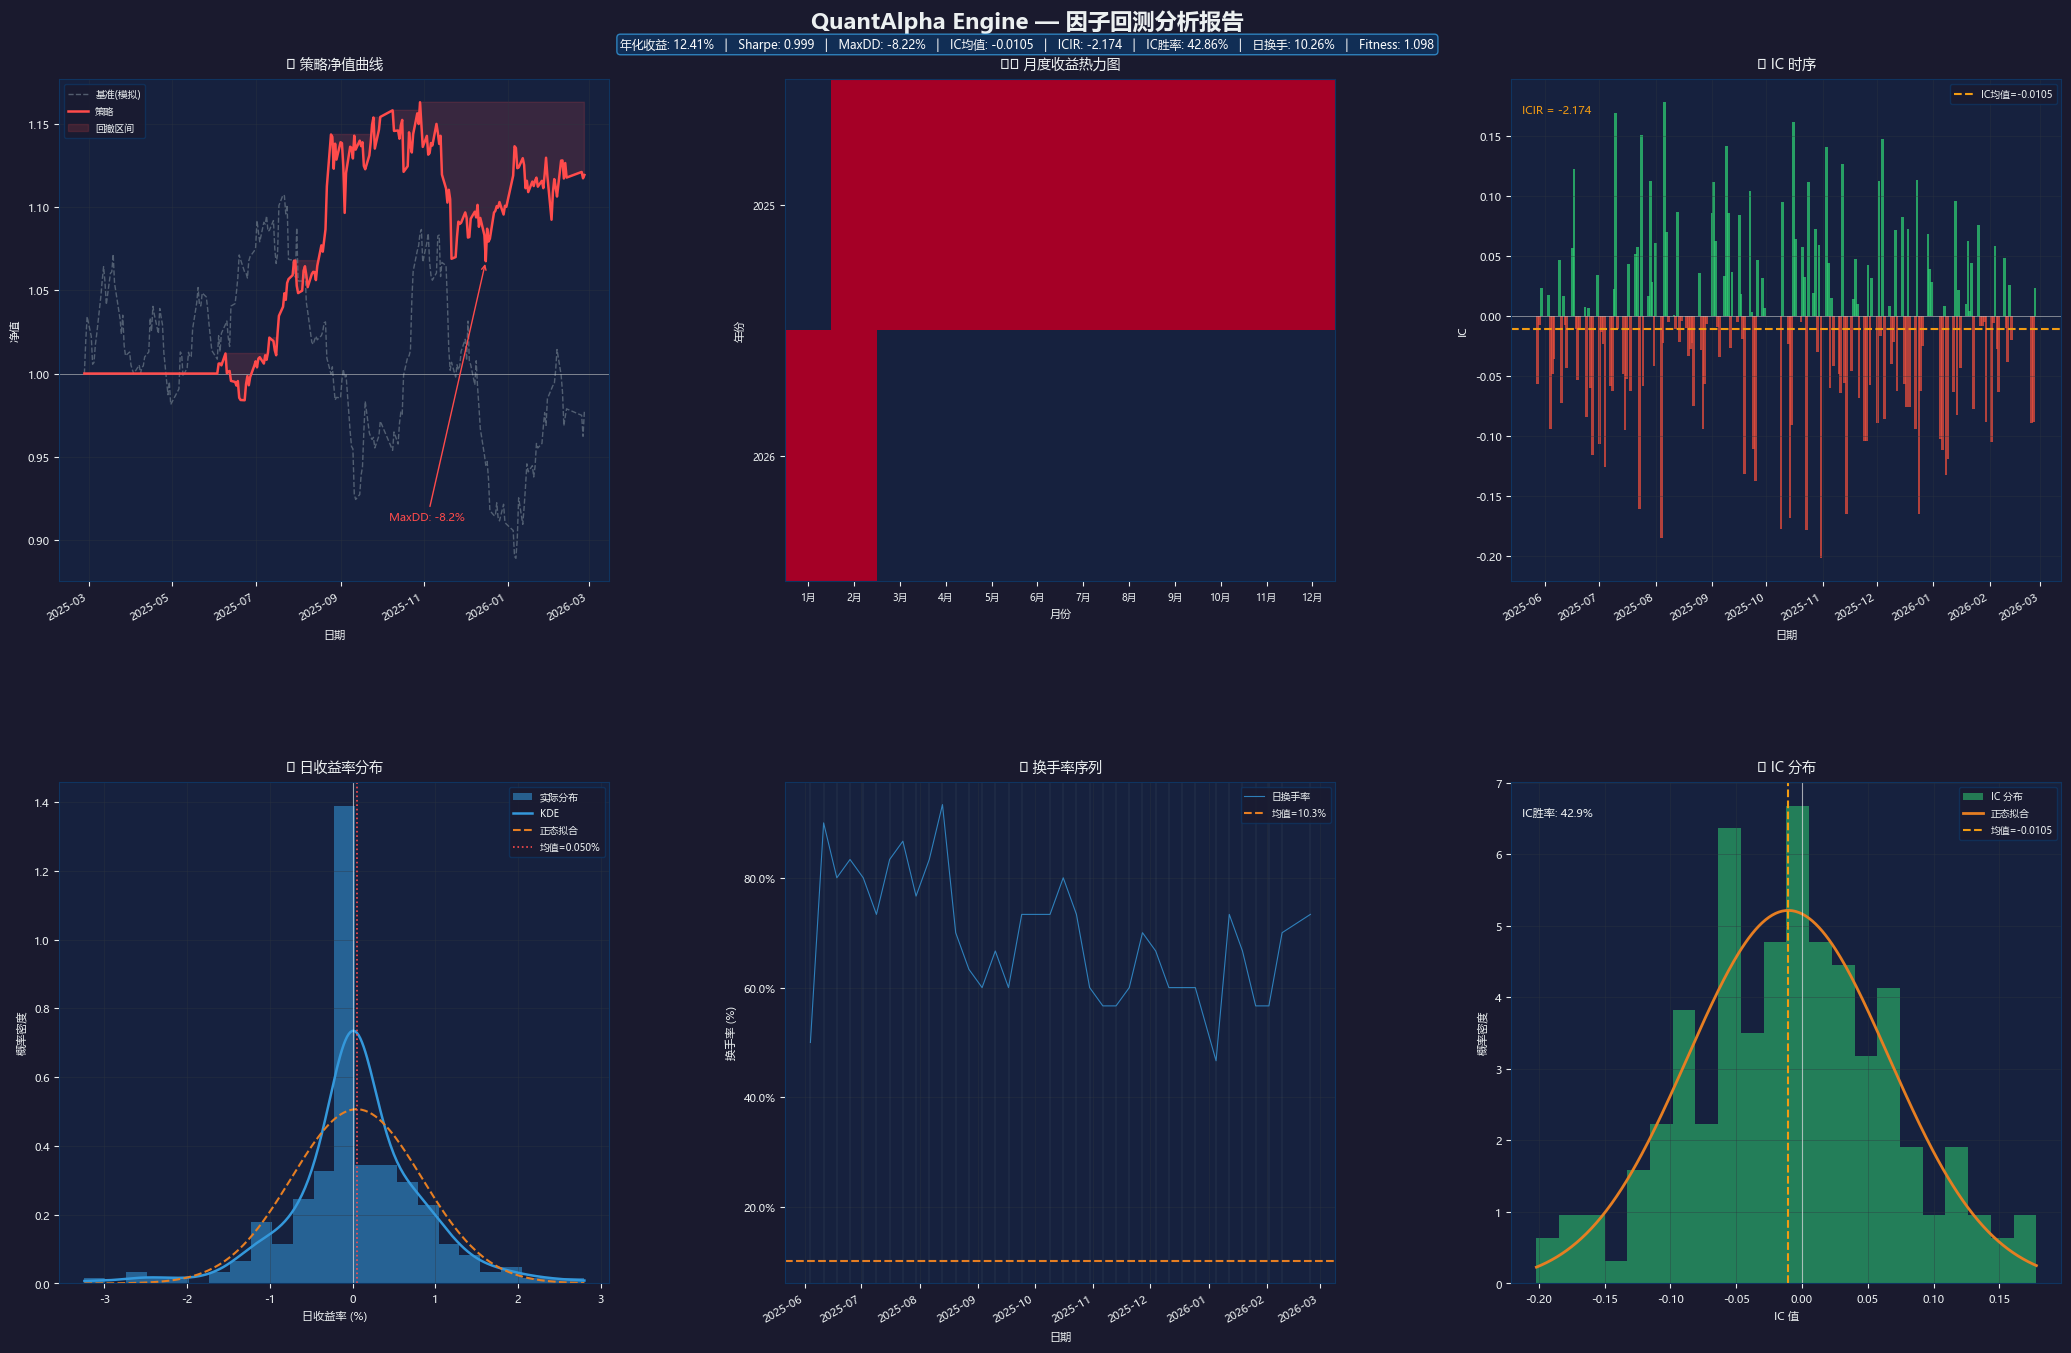

In [24]:
result_rl = ml_rf.evaluate(
    factors        = factors,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,      # MLCombiner expanding window 已防未来函数，无需延迟
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result_rl.print_summary()
result_rl.plot()

## §10. 融合效果对比

对比单因子 vs 统计融合 vs ML 融合的表现

---

## §10-A. VectorEngine 内置预处理：delay / decay / neutralize

v2.0 起 `VectorEngine` 支持三个预处理参数，无需在外部手动调用 AlphaOps：

| 参数 | 默认值 | 含义 |
|------|--------|------|
| `delay` | **1** | 因子延迟 N 天（1=T 日因子在 T+1 日后生效）；0 表示不延迟 |
| `decay` | 0 | 线性衰减窗口（WorldQuant `decay_linear`）；0 表示不衰减 |
| `industry` | None | 传入行业映射后自动做 OLS 行业中性化；None 跳过 |

**预处理顺序：delay → decay → neutralize**（顺序固定，符合标准因子流水线）

In [27]:
# 以 RSI 因子为例，演示三个预处理参数的效果
factor_demo = op.RSI(close, window=14)

# ── 1. 验证 delay：内置 delay=1 等价于手动 op.Ts_Delay(factor, 1) ────────
r_delay0 = VectorEngine(
    factor_demo, close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0,           # 不延迟
    start_date=START_DATE, end_date=END_DATE,
).run()

r_delay1 = VectorEngine(
    factor_demo, close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=1,           # 延迟 1 天（默认值）
    start_date=START_DATE, end_date=END_DATE,
).run()

# 手动 delay 验证
r_delay1_manual = VectorEngine(
    op.Ts_Delay(factor_demo, 1), close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0,
    start_date=START_DATE, end_date=END_DATE,
).run()
assert r_delay1.nav.round(8).equals(r_delay1_manual.nav.round(8)), '❌ delay 验证失败'
print(f'✅ delay 验证通过：内置 delay=1 与手动 Ts_Delay(factor,1) 结果完全一致')
print(f'  delay=0 Sharpe: {r_delay0.metrics["Sharpe_Ratio"]:+.4f}')
print(f'  delay=1 Sharpe: {r_delay1.metrics["Sharpe_Ratio"]:+.4f}')

# ── 2. 验证 decay：内置 decay=5 等价于手动 op.Decay_Linear(factor, 5) ──────
r_decay = VectorEngine(
    factor_demo, close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0, decay=5,  # 关闭 delay，只测 decay
    start_date=START_DATE, end_date=END_DATE,
).run()

r_decay_manual = VectorEngine(
    op.Decay_Linear(factor_demo, 5), close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0,
    start_date=START_DATE, end_date=END_DATE,
).run()
assert r_decay.nav.round(8).equals(r_decay_manual.nav.round(8)), '❌ decay 验证失败'
print(f'\n✅ decay 验证通过：内置 decay=5 与手动 Decay_Linear(factor,5) 结果完全一致')
print(f'  no-decay 日均换手: {r_delay0.metrics["日均换手率"]*100:.2f}%')
print(f'  decay=5  日均换手: {r_decay.metrics["日均换手率"]*100:.2f}%  (衰减平滑降低换手率)')

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=0, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=0, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

✅ delay 验证通过：内置 delay=1 与手动 Ts_Delay(factor,1) 结果完全一致
  delay=0 Sharpe: +3.6553
  delay=1 Sharpe: +0.7764
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=0, decay=5, neutralize=否
[VectorEngine] 构建持仓

In [28]:
# ── 3. 验证 neutralize：内置 industry= 等价于手动 op.Neutralize(factor, industry) ──
r_neut = VectorEngine(
    factor_demo, close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0, industry=industry,   # 传入行业序列
    start_date=START_DATE, end_date=END_DATE,
).run()

r_neut_manual = VectorEngine(
    op.Neutralize(factor_demo, industry), close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=0,
    start_date=START_DATE, end_date=END_DATE,
).run()
assert r_neut.nav.round(8).equals(r_neut_manual.nav.round(8)), '❌ neutralize 验证失败'
print(f'✅ neutralize 验证通过：内置 industry= 与手动 Neutralize(factor, industry) 结果完全一致')
print(f'  无中性化 Sharpe: {r_delay0.metrics["Sharpe_Ratio"]:+.4f}')
print(f'  行业中性 Sharpe: {r_neut.metrics["Sharpe_Ratio"]:+.4f}')

# ── 4. 组合使用：delay=1 + decay=5 + 行业中性化 ─────────────────────────────
print('\n── 组合预处理流水线 ──')
r_full = VectorEngine(
    factor_demo, close, is_susp, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=1,            # Step1: T日因子 → T+1日生效
    decay=5,            # Step2: 线性衰减平滑
    industry=industry,  # Step3: OLS行业中性化
    start_date=START_DATE, end_date=END_DATE,
).run()
r_full.print_summary()

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=0, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=0, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

✅ neutralize 验证通过：内置 industry= 与手动 Neutralize(factor, industry) 结果完全一致
  无中性化 Sharpe: +3.6553
  行业中性 Sharpe: +3.1719

── 组合预处理流水线 ──
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=5, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！



指标,数值,评价
年化收益率,+18.91%,良好
年化波动率,+16.86%,中风险
Sharpe Ratio,+1.1123,良好
Calmar Ratio,+2.0509,优秀
最大回撤,-9.22%,良好
IC 均值,-0.0144,较差
IC 标准差,+0.1246,稳定
ICIR,-1.8304,良好
IC 胜率,+41.41%,较差
IC t-stat,-1.7372,


In [29]:
# 单因子回测（以 f1/f2/f3 作为对比基准）
from quant_alpha_engine.backtest import VectorEngine

result_f1 = VectorEngine(
    factor         = f1,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
).run()

result_f2 = VectorEngine(
    factor         = f2,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
).run()

result_f3 = VectorEngine(
    factor         = f3,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
).run()

print('单因子回测完成')

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=是
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！

单因子回测完成


In [30]:
# 汇总对比表
all_results = {
    '短期反转(f1)':    result_f1,
    'RSI中性距(f2)':   result_f2,
    '风险调整动量(f3)': result_f3,
    'Stat-IC加权':     result_stat,
    'ML-Ridge':        result_ml,
}

key_cols = ['年化收益率', 'Sharpe_Ratio', '最大回撤', 'IC_Mean', 'ICIR', 'IC_胜率', 'Fitness']
rows = {}
for name, res in all_results.items():
    rows[name] = {k: res.metrics.get(k, float('nan')) for k in key_cols}

df_cmp = pd.DataFrame(rows).T

# 格式化
pct_cols = ['年化收益率', '最大回撤', 'IC_胜率']
df_fmt = df_cmp.copy()
for c in pct_cols:
    df_fmt[c] = df_cmp[c].apply(lambda v: f'{v*100:+.2f}%' if pd.notna(v) else 'N/A')
for c in ['Sharpe_Ratio', 'IC_Mean', 'ICIR', 'Fitness']:
    df_fmt[c] = df_cmp[c].apply(lambda v: f'{v:+.4f}' if pd.notna(v) else 'N/A')

print('\n======= 单因子 vs 融合器 — 绩效对比 =======')
print(df_fmt.to_string())


======= 单因子 vs 融合器 — 绩效对比 =======
              年化收益率 Sharpe_Ratio     最大回撤  IC_Mean     ICIR    IC_胜率  Fitness
短期反转(f1)    +15.48%      +0.9110  -12.01%  +0.0288  +4.1823  +58.23%  +0.9008
RSI中性距(f2)   +9.80%      +0.7336   -9.81%  +0.0042  +0.8048  +52.19%  +0.6084
风险调整动量(f3)  +14.86%      +0.9709   -7.90%  -0.0157  -2.1156  +43.24%  +1.2329
Stat-IC加权   +11.52%      +0.7996   -9.68%  +0.0005  +0.0701  +48.52%  +0.7864
ML-Ridge    +20.95%      +1.5194   -6.99%  -0.0223  -3.6158  +36.81%  +2.3252


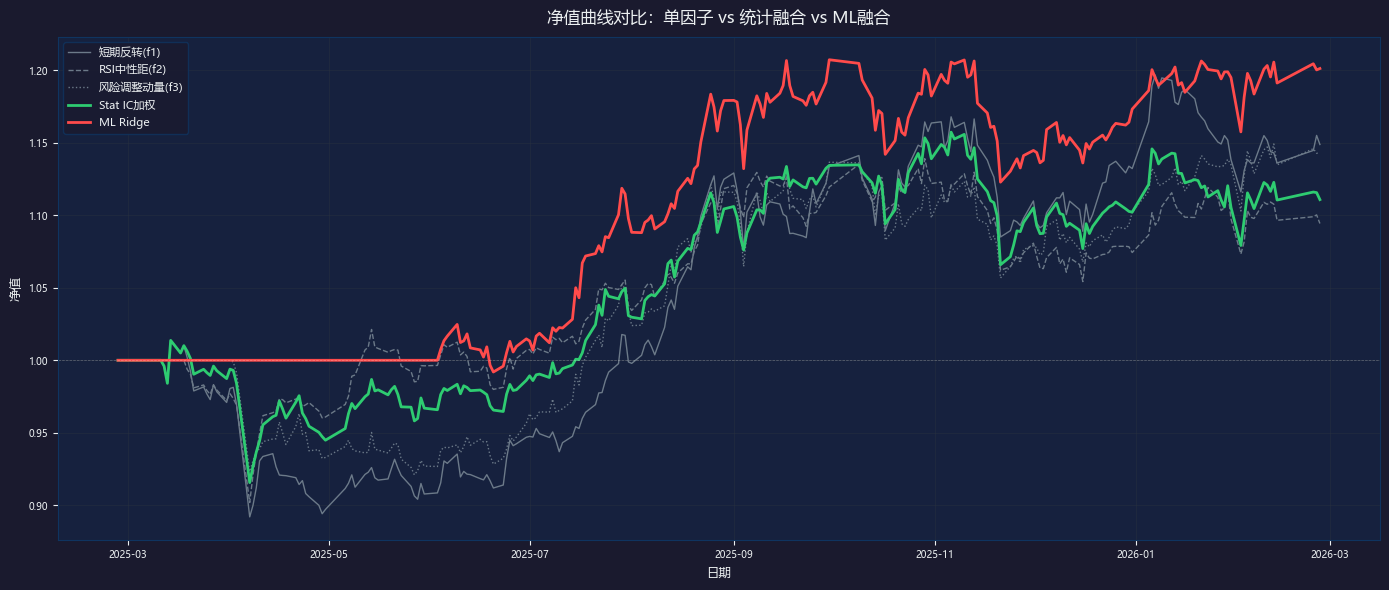

In [31]:
# 净值曲线对比
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')

plot_cfg = [
    (result_f1,   '短期反转(f1)',    '#6C7A89', 1.0, '-'),
    (result_f2,   'RSI中性距(f2)',   '#6C7A89', 1.0, '--'),
    (result_f3,   '风险调整动量(f3)','#6C7A89', 1.0, ':'),
    (result_stat, 'Stat IC加权',     '#2ECC71', 2.0, '-'),
    (result_ml,   'ML Ridge',        '#FF4B4B', 2.0, '-'),
]

for res, label, color, lw, ls in plot_cfg:
    nav = res.nav.dropna()
    ax.plot(nav.index, nav.values, label=label, color=color, linewidth=lw, linestyle=ls)

ax.axhline(1.0, color='white', linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_title('净值曲线对比：单因子 vs 统计融合 vs ML融合', color='#ECF0F1', fontsize=12, pad=10)
ax.set_xlabel('日期', color='#ECF0F1', fontsize=9)
ax.set_ylabel('净值', color='#ECF0F1', fontsize=9)
ax.legend(fontsize=8, facecolor='#1A1A2E', edgecolor='#0F3460', labelcolor='#ECF0F1')
ax.tick_params(colors='#ECF0F1', labelsize=7)
ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
for sp in ax.spines.values(): sp.set_color('#0F3460')

plt.tight_layout()
plt.show()

## §11. 模型持久化（save / load）

训练完成的 combiner 可以保存到文件，下次直接加载使用，无需重新训练。

In [23]:
import os

# ── 保存模型 ──────────────────────────────────────────────────
os.makedirs('models', exist_ok=True)

# StatisticalCombiner 保存
stat_ic.save('models/stat_ic_combiner.pkl')
print('StatisticalCombiner 已保存')

# MLCombiner - 含预测缓存（文件较大，加载后 predict 速度更快）
ml_ridge.save('models/ml_ridge_combiner.pkl', save_predictions=True)
print('MLCombiner (with predictions) 已保存')

# MLCombiner - 仅权重（文件更小）
ml_ridge.save('models/ml_ridge_weights_only.pkl', save_predictions=False)
print('MLCombiner (weights only) 已保存')

# 查看文件大小
for fname in os.listdir('models'):
    fpath = os.path.join('models', fname)
    size_kb = os.path.getsize(fpath) / 1024
    print(f'  {fname:<40}  {size_kb:.1f} KB')

StatisticalCombiner 已保存
MLCombiner (with predictions) 已保存
MLCombiner (weights only) 已保存
  ml_ridge_combiner.pkl                     404.0 KB
  ml_ridge_weights_only.pkl                 4.6 KB
  stat_ic_combiner.pkl                      16.6 KB


In [24]:
# ── 加载并验证 ────────────────────────────────────────────────
from quant_alpha_engine.fusion import FactorCombiner

# 加载 StatisticalCombiner
loaded_stat = FactorCombiner.load('models/stat_ic_combiner.pkl')
assert loaded_stat._is_fitted
assert np.allclose(loaded_stat.weights_, stat_ic.weights_)
print(f'✅ StatisticalCombiner 加载成功: {loaded_stat}')

# 加载 MLCombiner
loaded_ml = FactorCombiner.load('models/ml_ridge_combiner.pkl')
assert loaded_ml._is_fitted
print(f'✅ MLCombiner 加载成功: 模型数={len(loaded_ml._models)}')

# 验证预测结果一致
pred_orig   = ml_ridge.predict(factors)
pred_loaded = loaded_ml.predict(factors)
match = np.allclose(
    pred_orig.dropna(how='all').values,
    pred_loaded.dropna(how='all').values,
    equal_nan=True,
)
print(f'✅ 加载前后预测结果完全一致: {match}')

✅ StatisticalCombiner 加载成功: StatisticalCombiner(method='ic_weighted', is_fitted=True, weights_=[0.2071, 0.5487, -0.2443])
✅ MLCombiner 加载成功: 模型数=24
✅ 加载前后预测结果完全一致: True


---

## 附：新算子速查表 (v2.0)

```python
from quant_alpha_engine.ops import AlphaOps as op

# ── 时序扩展 ───────────────────────────────────────────────────────
op.Ts_Skew(df, window)                # 滚动偏度（三阶矩）
op.Ts_Kurt(df, window)                # 滚动超额峰度（四阶矩）
op.Ts_Autocorr(df, lag, window)       # 滚动 lag 阶自相关
op.Ts_Hurst(df, window)               # Hurst 指数（R/S 分析）

# ── 量价 ─────────────────────────────────────────────────────────
op.VWAP(close, volume, window)        # 滚动成交量加权均价
op.VWAP_Bias(close, volume, window)   # VWAP 乖离率 = Close/VWAP−1（百分比，有量纲）
op.PVDeviation(close, volume, window) # 价格偏离 VWAP 的标准化距离（无量纲）
op.Amihud(close, volume, window)      # Amihud 非流动性指标

# VWAP_Bias 信号用法：
#   均值回归信号（大幅低于 VWAP → 反弹）：op.Rank(-op.VWAP_Bias(close, volume, w))
#   趋势跟踪信号（持续高于 VWAP → 动量）：op.Rank( op.VWAP_Bias(close, volume, w))

# ── 动量 ─────────────────────────────────────────────────────────
op.RiskAdjMomentum(close, window, vol_window)  # 风险调整动量
op.PricePathQuality(close, window)             # 路径质量 [0,1]
op.RangeBreakout(close, high, low, window)     # 区间突破位置 [0,1]

# ── 技术指标 ──────────────────────────────────────────────────────
op.RSI(close, window=14)                       # 相对强弱指标 [0,100]
op.KDJ(close, high, low, n=9, m1=3, m2=3)    # KDJ K 值
op.MACD(close, fast=12, slow=26, signal=9)    # MACD 柱状图

# ── VectorEngine 内置预处理（v2.0 新增）───────────────────────────
# delay=d 语义：用 T-d 日因子预测 T 日收益
#   delay=1（默认）：T-1日收盘计算因子 → T日开盘执行 → 赚T日收益，严格无未来函数
#   delay=0：T日因子预测T日收益，存在 look-ahead bias，仅供研究
result = VectorEngine(
    factor, close, is_suspended, is_limit,
    rebalance_freq=5, top_n=30, cost_rate=0.0015,
    delay=1,            # T-1日因子预测T日收益（默认，推荐）
    decay=5,            # 线性衰减窗口（默认0=不衰减）
    industry=industry,  # 行业映射，传 None 跳过中性化（默认）
).run()

# ── 融合（fusion 模块）────────────────────────────────────────────
from quant_alpha_engine.fusion import Labeler, StatisticalCombiner, MLCombiner

y = Labeler().set_label(target='close', horizon=5, data={'close': close})
y = Labeler().set_label(custom_label=my_df)         # 自定义优先

stat = StatisticalCombiner('ic_weighted').fit([f1,f2,f3], y)
# evaluate() 同样支持 delay/decay/industry 三个预处理参数
result = stat.evaluate(
    [f1,f2,f3], close=close, is_suspended=..., is_limit=...,
    rebalance_freq=5, top_n=30,
    delay=1,            # T-1日因子预测T日收益（推荐）
    decay=0,            # 默认不衰减
    industry=None,      # 默认不中性化
)

ml = MLCombiner('ridge', min_train_periods=60, refit_freq=20).fit([f1,f2,f3], y)
ml.save("model.pkl")                         # 保存
ml2 = MLCombiner.load("model.pkl")           # 加载
```